**Dataset**\
Each row in the dataset is anonymized real policy data. A policy is considered churned if the difference between the start and end date is less than 1 year.

**Problem**\
Develop a model to predict a policy's probability to churn at time of sale.

In [94]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score


In [43]:
df = pd.read_csv(os.getcwd() + '/churn_data.csv', parse_dates=['start_date','end_date'])

In [44]:
df.head()

,customer_id,start_date,end_date,years_of_experience,channel,geo,profession_id,cancellation_reason
0,d18013b0edd9a43a0fdb67c8cfbc3342,2019-09-05,2019-11-04,5.0,channel sales,TX,5010,Non-Payment
1,9f618809d3a625ddd81ce0d8237c99dd,2020-02-24,2020-04-14,5.0,organic,OH,100003,Insured is no longer in business
2,47e9c803736f0999430324aaaba6046c,2019-08-26,2019-10-26,5.0,sem,FL,5006,Non-Payment
3,825463b772f05057975b61988718e6af,2019-10-09,2019-11-18,10.0,sem,OH,100001,I had a short-term need for insurance that has...
4,66a8c47b8ecaaed6fc1031b1d9ab1e3c,2019-04-08,2020-04-08,5.0,sem,MD,100040,NaN


In [45]:
df.shape

(30000, 8)

In [46]:
df.isna().sum()

customer_id                0
start_date                 0
end_date                   0
years_of_experience        0
channel                   66
geo                        0
profession_id              0
cancellation_reason    19116
dtype: int64

In [47]:
df.dtypes

customer_id                    object
start_date             datetime64[ns]
end_date               datetime64[ns]
years_of_experience           float64
channel                        object
geo                            object
profession_id                   int64
cancellation_reason            object
dtype: object

In [48]:
df.describe()

,years_of_experience,profession_id
count,30000.000000,30000.000000
mean,7.906867,43627.378333
std,8.038504,46832.667790
min,0.000000,5003.000000
25%,5.000000,5006.000000
50%,5.000000,5010.000000
75%,7.000000,100001.000000
max,171.000000,111656.000000


{'whiskers': [<matplotlib.lines.Line2D at 0x12da26518>,
 'caps': [<matplotlib.lines.Line2D at 0x12da26be0>,
 'boxes': [<matplotlib.lines.Line2D at 0x12da263c8>],
 'medians': [<matplotlib.lines.Line2D at 0x12d6222b0>],
 'fliers': [<matplotlib.lines.Line2D at 0x12d6225f8>],
 'means': []}

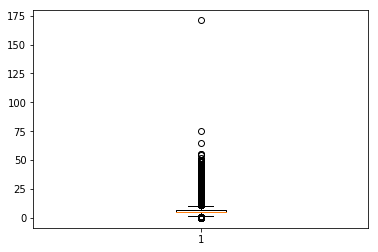

In [49]:
plt.boxplot(df['years_of_experience'])

{'whiskers': [<matplotlib.lines.Line2D at 0x12d64fd30>,
 'caps': [<matplotlib.lines.Line2D at 0x12e5b7438>,
 'boxes': [<matplotlib.lines.Line2D at 0x12d64fbe0>],
 'medians': [<matplotlib.lines.Line2D at 0x12e5b7ac8>],
 'fliers': [<matplotlib.lines.Line2D at 0x12e5b7e10>],
 'means': []}

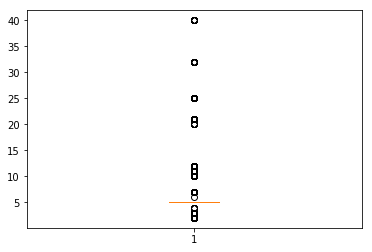

In [50]:
df = df[df['years_of_experience'] < 100] 
plt.boxplot(df.loc[df['years_of_experience'], 'years_of_experience'])

In [51]:
df.start_date.max()

Timestamp('2020-10-02 00:00:00')

In [52]:
df.start_date.min()

Timestamp('2018-01-17 00:00:00')

In [53]:
df.end_date.min()

Timestamp('2018-02-26 00:00:00')

In [54]:
df.end_date.max()

Timestamp('2021-10-02 00:00:00')

In [55]:
today = datetime.date.today()

In [56]:
df.loc[df['end_date'] > today, 'end_date']

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  """Entry point for launching an IPython kernel.


5       2021-01-13
8       2020-12-04
9       2021-09-28
14      2021-01-31
22      2021-04-03
25      2021-02-03
26      2021-02-05
30      2021-05-14
32      2021-06-04
33      2021-03-27
36      2021-07-29
44      2021-02-21
45      2021-05-29
51      2021-09-16
52      2021-08-21
54      2021-02-24
57      2021-08-27
64      2020-12-02
73      2021-09-08
82      2020-11-12
84      2021-02-27
86      2021-08-29
87      2021-03-12
88      2021-06-16
95      2021-04-13
99      2021-07-01
103     2021-04-22
105     2020-12-11
107     2021-04-28
112     2021-06-09
           ...    
29893   2021-09-11
29894   2021-05-16
29899   2020-11-25
29901   2021-06-18
29902   2020-12-01
29904   2021-03-31
29910   2021-03-23
29914   2021-04-13
29916   2021-05-01
29919   2021-04-28
29924   2021-08-26
29931   2021-09-30
29934   2021-06-05
29945   2020-12-16
29955   2021-05-10
29960   2021-02-10
29963   2021-09-22
29965   2021-09-10
29966   2021-04-23
29968   2021-05-11
29970   2021-03-09
29974   2021

In [57]:
df['start_plus_1'] = df['start_date'] + pd.DateOffset(years=1)
df.loc[df['end_date'] > df['start_plus_1'],]

,customer_id,start_date,end_date,years_of_experience,channel,geo,profession_id,cancellation_reason,start_plus_1


In [58]:
for col in ['channel', 'geo', 'profession_id', 'cancellation_reason']:
    print(df[col].value_counts())
    print(len(df[col].value_counts()))

sem              16853
agents            4434
organic           3172
social            1921
channel sales     1277
direct             792
display            512
support            392
video              391
email              153
unknown             31
native               5
Name: channel, dtype: int64
12
FL    3482
CO    3398
CA    2805
TX    1753
GA    1289
PA    1145
NC    1027
OH     962
NJ     960
MI     824
IL     819
OR     744
MA     719
VA     693
SC     639
TN     599
IN     524
MO     481
AL     462
WA     459
KY     441
WI     431
MN     424
AZ     421
ME     341
MD     312
OK     292
CT     287
ID     285
UT     280
NH     279
MT     253
KS     244
IA     216
AR     203
RI     203
LA     203
NE     134
MS     131
NM     131
DE     117
NV     113
WV      91
VT      86
WY      69
SD      63
ND      60
AK      44
HI      33
DC      28
Name: geo, dtype: int64
50
100001    6680
5006      5789
5005      3385
5010      2604
5003      1954
5013      1102
100003    1052
100002    1

In [59]:
cols = ['channel', 'geo']
le = preprocessing.LabelEncoder()
for col in cols:
    df[f'{col}_transformed'] = le.fit_transform(df[col].fillna('unknown'))
df.head()

,customer_id,start_date,end_date,years_of_experience,channel,geo,profession_id,cancellation_reason,start_plus_1,channel_transformed,geo_transformed
0,d18013b0edd9a43a0fdb67c8cfbc3342,2019-09-05,2019-11-04,5.0,channel sales,TX,5010,Non-Payment,2020-09-05,1,42
1,9f618809d3a625ddd81ce0d8237c99dd,2020-02-24,2020-04-14,5.0,organic,OH,100003,Insured is no longer in business,2021-02-24,6,34
2,47e9c803736f0999430324aaaba6046c,2019-08-26,2019-10-26,5.0,sem,FL,5006,Non-Payment,2020-08-26,7,9
3,825463b772f05057975b61988718e6af,2019-10-09,2019-11-18,10.0,sem,OH,100001,I had a short-term need for insurance that has...,2020-10-09,7,34
4,66a8c47b8ecaaed6fc1031b1d9ab1e3c,2019-04-08,2020-04-08,5.0,sem,MD,100040,NaN,2020-04-08,7,20


In [60]:
df['churned'] = np.where(df['start_plus_1'] > df['end_date'], 1, 0)
df.head()

,customer_id,start_date,end_date,years_of_experience,channel,geo,profession_id,cancellation_reason,start_plus_1,channel_transformed,geo_transformed,churned
0,d18013b0edd9a43a0fdb67c8cfbc3342,2019-09-05,2019-11-04,5.0,channel sales,TX,5010,Non-Payment,2020-09-05,1,42,1
1,9f618809d3a625ddd81ce0d8237c99dd,2020-02-24,2020-04-14,5.0,organic,OH,100003,Insured is no longer in business,2021-02-24,6,34,1
2,47e9c803736f0999430324aaaba6046c,2019-08-26,2019-10-26,5.0,sem,FL,5006,Non-Payment,2020-08-26,7,9,1
3,825463b772f05057975b61988718e6af,2019-10-09,2019-11-18,10.0,sem,OH,100001,I had a short-term need for insurance that has...,2020-10-09,7,34,1
4,66a8c47b8ecaaed6fc1031b1d9ab1e3c,2019-04-08,2020-04-08,5.0,sem,MD,100040,NaN,2020-04-08,7,20,0


In [61]:
df['churned'].value_counts()

0    19123
1    10876
Name: churned, dtype: int64

In [96]:
19123 / (19123 + 10876)

0.637454581819394

In [98]:
df['random'] = np.random.random(size=df.shape[0])
df.head()

,customer_id,start_date,end_date,years_of_experience,channel,geo,profession_id,cancellation_reason,start_plus_1,channel_transformed,geo_transformed,churned,yhat,random
0,d18013b0edd9a43a0fdb67c8cfbc3342,2019-09-05,2019-11-04,5.0,channel sales,TX,5010,Non-Payment,2020-09-05,1,42,1,0,0.766635
1,9f618809d3a625ddd81ce0d8237c99dd,2020-02-24,2020-04-14,5.0,organic,OH,100003,Insured is no longer in business,2021-02-24,6,34,1,0,0.780608
2,47e9c803736f0999430324aaaba6046c,2019-08-26,2019-10-26,5.0,sem,FL,5006,Non-Payment,2020-08-26,7,9,1,0,0.815802
3,825463b772f05057975b61988718e6af,2019-10-09,2019-11-18,10.0,sem,OH,100001,I had a short-term need for insurance that has...,2020-10-09,7,34,1,0,0.941765
4,66a8c47b8ecaaed6fc1031b1d9ab1e3c,2019-04-08,2020-04-08,5.0,sem,MD,100040,NaN,2020-04-08,7,20,0,0,0.051251


In [99]:
np.mean(df['random'])

0.49812731222203926

In [87]:
X = df[['years_of_experience', 'channel_transformed', 'geo_transformed', 'profession_id']]
y = df.churned

In [88]:
X.isna().sum()

years_of_experience    0
channel_transformed    0
geo_transformed        0
profession_id          0
dtype: int64

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=17, test_size=0.2)

In [90]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)


RandomForestClassifier()

In [92]:
df['yhat'] = rf.predict(X)
test_df = pd.concat([X_test, y_test], axis=1)
test_df['yhat'] = rf.predict_proba(X_test)[:,1]


In [93]:
test_df.head()

,years_of_experience,channel_transformed,geo_transformed,profession_id,churned,yhat
15853,5.0,6,4,5010,0,0.120256
7388,5.0,1,19,5013,1,0.243155
1799,40.0,7,3,100001,1,0.064973
735,5.0,6,14,5003,0,0.113681
10822,10.0,0,10,100001,0,0.564333


In [95]:
roc_auc_score(test_df['churned'], test_df['yhat'])

0.5945614008404347

In [100]:
roc_auc_score(df['churned'], df['random'])

0.5000136887011835

In [102]:
train_df = pd.concat([X_train, y_train], axis=1)
train_df['yhat'] = rf.predict_proba(X_train)[:,1]
roc_auc_score(train_df['churned'], train_df['yhat'])

0.8673928238322872

In [105]:
rf2 = RandomForestClassifier(max_depth=5)
rf2.fit(X_train, y_train)


RandomForestClassifier(max_depth=5)

In [106]:
df['yhat2'] = rf2.predict(X)
test_df['yhat2'] = rf2.predict_proba(X_test)[:,1]


In [107]:
roc_auc_score(test_df['churned'], test_df['yhat2'])

0.628924177394208